In [73]:
import ast
import torch
torch.cuda.current_device()

import pickle
torch.set_default_dtype(torch.float64)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append("../..")

from prediction.evaluation import compute_rNMSEs_per_step, compute_iteration_rNMSE
from prediction.pred_utils import get_device, transform_data_to_all_steps_prediction, \
    convert_data_to_graph_time_pr_graph, get_name_string, get_dataset

from architectures.space_time.parametric_pooling_net_ordering import ParametricNetWithPoolingOrdered

from utils.graph_utils import permutation_by_degree

device = get_device(use_gpu=True)

Device selected: cuda:0


In [74]:
# runs_dir = "C:\\Users\\gabri\\Desktop\\exp_prediction_MOLENE\\grid_search_2l_taps=[2, 2]\\full\\"
# model_name = "20200127230508_1step-GTCNN_lr=0.005_b=150_L=2_F=[8, 2]_T=[2, 2]_P=[4, 1]_R=[1, 1]_N=[32, 32]"

runs_dir = "C:\\Users\\gabri\\Desktop\\new_thesis_project\\prediction\\NOAA\\runs_NOAA_w=4\\"
model_name = "20200203093847_lr=0.01_b=128_w=4_L=2_F=[4, 8]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[109, 21]_wd=0_cyclic=True_lambda=0_tdirect=True"
model_path = runs_dir + model_name

In [75]:
elements = model_name.split("_")[5:]
elements

['F=[4, 8]',
 'T=[2, 2]',
 'P=[1, 4]',
 'R=[1, 1]',
 'N=[109, 21]',
 'wd=0',
 'cyclic=True',
 'lambda=0',
 'tdirect=True']

In [76]:
cyclic = 'cyclic=True' in model_name
time_directed = 'tdirect=False' not in model_name

print(f"Cyclic: {cyclic}")
print(f"Time directed: {time_directed}")

Cyclic: True
Time directed: True


In [77]:
BEST = True
NORMALIZE_ADJACENCY_MATRIX = False

# --------------------------------------------------------------------------------------

# Loading the data

In [78]:
ds_type = "NOAA"
ds_folder=r"../../prediction/"
splits = [0.35, 0.15, 0.5]
obs=4


dataset, observation_window, N_spatial_nodes, steps_ahead, weighted_adj, in_sample_means = get_dataset(
    ds_type,
    ds_folder,
    NORMALIZE_ADJACENCY_MATRIX,
    splits=splits,
    obs_window=obs
)
print(f"{N_spatial_nodes} nodes - {observation_window} observed timesteps - steps ahead: {steps_ahead}")



NOAA is selected



Dataset path: ../../prediction//NOAA/dataset/processed/NOA_w=4_steps=[1, 2, 3, 4, 5]_splits=[0.35, 0.15, 0.5].pickle
Sample means: ../../prediction//NOAA/dataset/processed/in_sample_means_0.5.pickle
109 nodes - 4 observed timesteps - steps ahead: [1, 2, 3, 4, 5]


In [79]:
# Get data (We do not need test data/labels here)
_, _, tst_data, _, _, tst_labels = transform_data_to_all_steps_prediction(dataset, node_first=True, device=device)

print(tst_data.shape, tst_labels.shape)

torch.Size([4372, 1, 109, 4]) torch.Size([4372, 5, 109])


# Create the model
This must match the model we are going to load from the checkpoint

In [80]:
import ast


start = 5

features = ast.literal_eval(model_name.split("_")[start].split("=")[1])
taps = ast.literal_eval(model_name.split("_")[start+1].split("=")[1])
pool_ratios = ast.literal_eval(model_name.split("_")[start+2].split("=")[1])
reach = ast.literal_eval(model_name.split("_")[start+3].split("=")[1])
nodes = ast.literal_eval(model_name.split("_")[start+4].split("=")[1])

for elem in [features, taps, pool_ratios, reach, nodes]:
    print(elem)

[4, 8]
[2, 2]
[1, 4]
[1, 1]
[109, 21]


In [81]:
feat_per_layer = [1] + features
taps_per_layer = taps
pool_reach_per_layer = reach
active_nodes_per_timestep_per_layer = [N_spatial_nodes] + nodes
time_pooling_ratio_per_layer = pool_ratios



one_step_gtcnn = ParametricNetWithPoolingOrdered(
    window=observation_window,
    cyclic_time_graph=cyclic,
    time_directed=time_directed,
    S_spatial=weighted_adj,
    n_feat_per_layer=feat_per_layer,
    n_taps_per_layer=taps_per_layer,
    n_active_nodes_per_timestep_per_layer=active_nodes_per_timestep_per_layer,
    time_pooling_ratio_per_layer=time_pooling_ratio_per_layer,
    pool_reach_per_layer=pool_reach_per_layer,
    output_dim=N_spatial_nodes,
    device=device)

one_step_gtcnn.to(device)
print(one_step_gtcnn)

ParametricNetWithPoolingOrdered(
  (GFL): Sequential(
    (0): ParametricGraphFilter(in_features=1, out_features=4, filter_taps=2, edge_features=1, timesteps= 4, h_00= 1.0, h_01= 1.0, h_10= 1.0, h_11= 1.0	# params= 16)
    (1): ReLU()
    (2): SpaceTimeMaxPooling(nodes_in=436, nodes_out=436, hops=1, steps_in=4, steps_out=4, tot_st_nodes=436, time_pooling_step= 1, slices_to_pool=[0, 1, 2, 3])
    (3): ParametricGraphFilter(in_features=4, out_features=8, filter_taps=2, edge_features=1, timesteps= 4, h_00= 1.0, h_01= 1.0, h_10= 1.0, h_11= 1.0	# params= 76)
    (4): ReLU()
    (5): SpaceTimeMaxPooling(nodes_in=436, nodes_out=21, hops=1, steps_in=4, steps_out=1, tot_st_nodes=436, time_pooling_step= 4, slices_to_pool=[0])
  )
  (fc): Linear(in_features=168, out_features=109, bias=True)
)


In [82]:
model_parameters = filter(lambda p: p.requires_grad, one_step_gtcnn.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of parameters: {params}")

Number of parameters: 18513


# Load the model

In [83]:
naming = "best" if BEST else "last"
checkpoint = torch.load(f"{model_path}/{naming}_one_step_gtcnn.pth") 

one_step_gtcnn.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']

one_step_gtcnn.eval()
print(f"{naming} model was at epoch: {epoch}")

start = 100
width = 100
end = start+width

rNMSE_dict, predictions_dict = compute_iteration_rNMSE(one_step_gtcnn, steps_ahead, tst_data, tst_labels, device, verbose=False)

best model was at epoch: 39


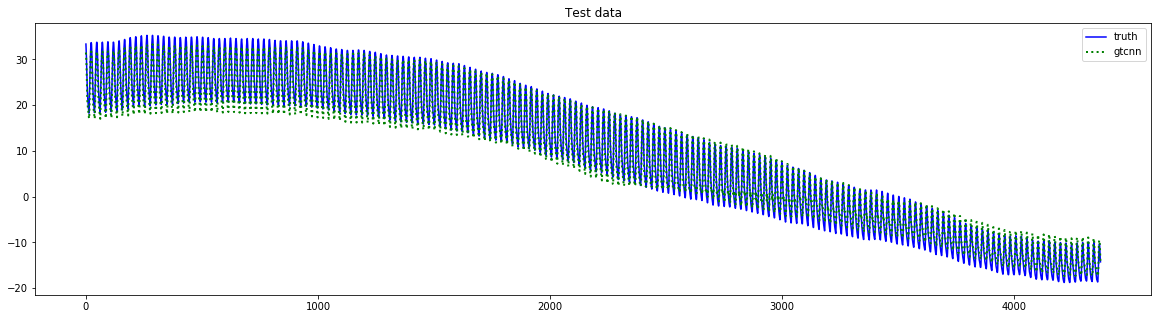

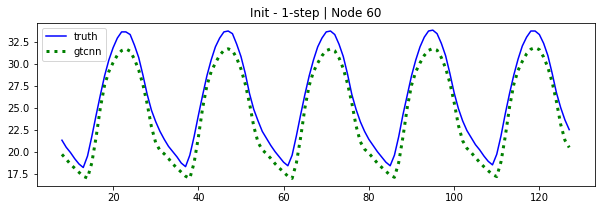

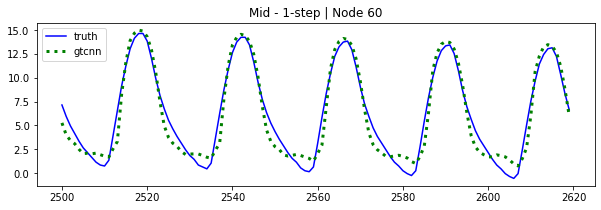

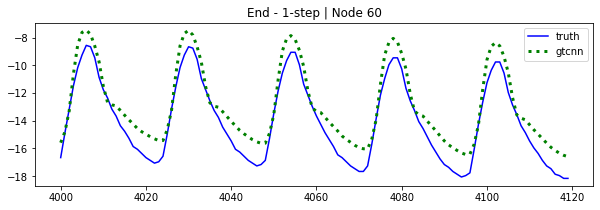

39
{1: tensor(0.1429, device='cuda:0'), 2: tensor(0.1796, device='cuda:0'), 3: tensor(0.2394, device='cuda:0'), 4: tensor(0.2871, device='cuda:0'), 5: tensor(0.3419, device='cuda:0')}


In [96]:
node_to_visualize = 60  # 0, 2 ,7, 13 20, 50      16   best:7
step_ahead = 1

pred = predictions_dict[step_ahead][:, node_to_visualize].cpu()
truth = tst_labels[:, step_ahead-1, node_to_visualize].cpu()
assert pred.shape == truth.shape
indices = list(range(truth.shape[0]))

truth_style = '-'
pred_style = ':'
# plot of all_data
plt.figure(figsize=(20, 5))
plt.plot(indices, truth[indices], 'b', linestyle=truth_style, label='truth')  # plotting t, a separately
plt.plot(indices, pred[indices], 'g', linestyle=pred_style, label='gtcnn', linewidth=2)  # plotting t, b separately
# plt.axvline(x=int(len(indices)* in_sample), c='g', linestyle='-')
plt.title("Test data")
plt.legend()
plt.show()


# plot of [4380:4460] indices like in elvin paper
width=120
start = 8
end = start + width
plt.figure(figsize=(10, 3))
plt.plot(indices[start:end], truth[start:end], 'b', linestyle=truth_style, label='truth')  # plotting t, a separately
plt.plot(indices[start:end], pred[start:end], 'g', linestyle=pred_style, label='gtcnn', linewidth=3)  # plotting t, b separately
# plt.axvline(x=int(len(indices)* in_sample), c='g', linestyle='-')
plt.title(f"Init - {step_ahead}-step | Node {node_to_visualize}")
plt.legend()
plt.show()


# plot of [4380:4460] indices like in elvin paper
start = 2500
end = start + width
plt.figure(figsize=(10, 3))
plt.plot(indices[start:end], truth[start:end], 'b', linestyle=truth_style, label='truth')  # plotting t, a separately
plt.plot(indices[start:end], pred[start:end], 'g', linestyle=pred_style, label='gtcnn', linewidth=3)  # plotting t, b separately
# plt.axvline(x=int(len(indices)* in_sample), c='g', linestyle='-')
plt.title(f"Mid - {step_ahead}-step | Node {node_to_visualize}")
plt.legend()
plt.show()


start = 4000
end = start + width
plt.figure(figsize=(10, 3))
plt.plot(indices[start:end], truth[start:end], 'b', linestyle=truth_style, label='truth')  # plotting t, a separately
plt.plot(indices[start:end], pred[start:end], 'g', linestyle=pred_style, label='gtcnn', linewidth=3)  # plotting t, b separately
# plt.axvline(x=int(len(indices)* in_sample), c='g', linestyle='-')
plt.title(f"End - {step_ahead}-step | Node {node_to_visualize}")
plt.legend()
plt.show()


print(epoch)
print(rNMSE_dict)

# Computing metrics

In [85]:
trn_data, val_data, tst_data, trn_labels, val_labels, tst_labels = transform_data_to_all_steps_prediction(dataset, node_first=True, device=device)

In [86]:
def itemize_dictionary(dictionary, round_digits):
    for k,i in dictionary.items():
        dictionary[k] = round(i.item(), round_digits)
    return dictionary

In [87]:
rNMSEs_trn_dict, trn_predictions = compute_iteration_rNMSE(one_step_gtcnn, steps_ahead, trn_data, trn_labels, device, verbose=False)
rNMSEs_trn_dict = itemize_dictionary(rNMSEs_trn_dict, 3)
avg_trn_rNMSE = round(np.average(list(rNMSEs_trn_dict.values())), 5)
print(f"Average rNMSE on trn set: {avg_trn_rNMSE}")
print(f"rNMSE per step on trn set: {rNMSEs_trn_dict}")

rNMSEs_val_dict, val_predictions = compute_iteration_rNMSE(one_step_gtcnn, steps_ahead, val_data, val_labels, device, verbose=False)
rNMSEs_val_dict = itemize_dictionary(rNMSEs_val_dict, 3)
avg_val_rNMSE = round(np.average(list(rNMSEs_val_dict.values())), 5)
print(f"\nAverage rNMSE on val set: {avg_val_rNMSE}")
print(f"rNMSE per step on val set: {rNMSEs_val_dict}")

rNMSEs_tst_dict, tst_predictions = compute_iteration_rNMSE(one_step_gtcnn, steps_ahead, tst_data, tst_labels, device, verbose=False)
rNMSEs_tst_dict = itemize_dictionary(rNMSEs_tst_dict, 3)
avg_tst_rNMSE = round(np.average(list(rNMSEs_tst_dict.values())), 5)
print(f"\nAverage rNMSE on test set: {avg_tst_rNMSE}")
print(f"rNMSE per step on test set: {rNMSEs_tst_dict}")

print("\n", model_path)

print("\n", epoch)

Average rNMSE on trn set: 0.1896
rNMSE per step on trn set: {1: 0.081, 2: 0.13, 3: 0.196, 4: 0.247, 5: 0.294}

Average rNMSE on val set: 0.1426
rNMSE per step on val set: {1: 0.089, 2: 0.105, 3: 0.137, 4: 0.17, 5: 0.212}

Average rNMSE on test set: 0.2382
rNMSE per step on test set: {1: 0.143, 2: 0.18, 3: 0.239, 4: 0.287, 5: 0.342}

 C:\Users\gabri\Desktop\new_thesis_project\prediction\NOAA\runs_NOAA_w=4\20200203093847_lr=0.01_b=128_w=4_L=2_F=[4, 8]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[109, 21]_wd=0_cyclic=True_lambda=0_tdirect=True

 39


In [88]:
BEST

True

Average rNMSE on trn set: 0.1976
rNMSE per step on trn set: {1: 0.084, 2: 0.133, 3: 0.199, 4: 0.256, 5: 0.316}

Average rNMSE on val set: 0.1594
rNMSE per step on val set: {1: 0.093, 2: 0.115, 3: 0.157, 4: 0.196, 5: 0.236}

Average rNMSE on test set: 0.2282
rNMSE per step on test set: {1: 0.14, 2: 0.174, 3: 0.23, 4: 0.274, 5: 0.323}

 C:\Users\gabri\Desktop\new_thesis_project\prediction\NOAA\runs_NOAA_w=4\20200203093847_lr=0.01_b=128_w=4_L=2_F=[4, 8]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[109, 21]_wd=0_cyclic=True_lambda=0_tdirect=True

 32

In [89]:
g_varma_rNMSEs = [0.0344, 0.0887, 0.1537, 0.2217, 0.2876]
gp_var_rNMSEs = [0.0402, 0.1013, 0.1730, 0.2487, 0.3246]
# persistence = [0.2344, 0.3757, 0.5024, 0.6143, 0.7105]

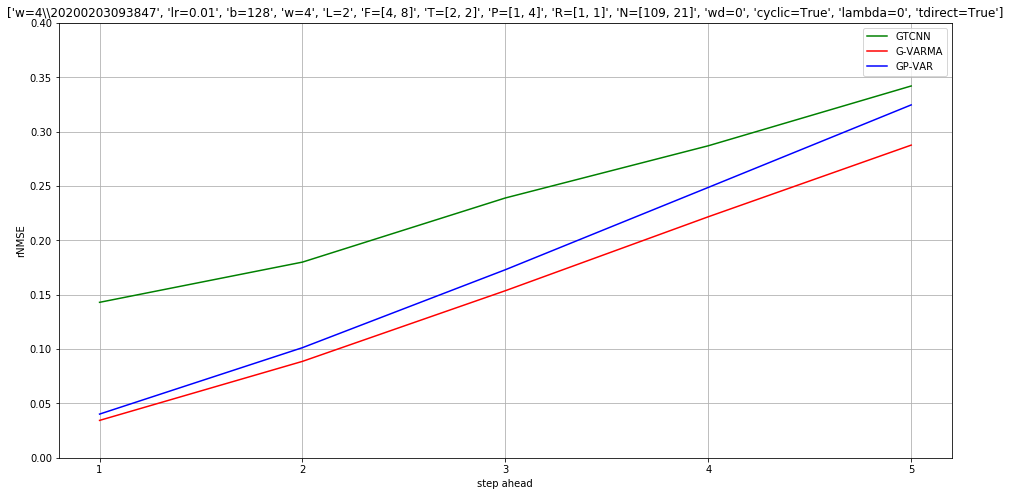

NOAA


In [90]:
from matplotlib.ticker import MaxNLocator



ax = plt.figure(figsize=(16, 8)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(steps_ahead, list(rNMSEs_tst_dict.values()), 'g', label='GTCNN')
plt.plot(steps_ahead, g_varma_rNMSEs, 'r', label='G-VARMA')
plt.plot(steps_ahead, gp_var_rNMSEs, 'b', label='GP-VAR')
# plt.plot(steps_ahead, persistence, 'y', label='Persistence')


plt.xlabel("step ahead")
plt.ylabel("rNMSE")
plt.legend()
plt.title(model_path.split("_")[4:])
plt.grid()
plt.ylim(0, 0.4)
plt.show()

print(model_path.split("_")[3])

In [91]:
print(f"Average rNMSE on trn set: {avg_trn_rNMSE}")
print(f"rNMSE per step on trn set: {rNMSEs_trn_dict}")
print(f"\nAverage rNMSE on val set: {avg_val_rNMSE}")
print(f"rNMSE per step on val set: {rNMSEs_val_dict}")
print(f"\nAverage rNMSE on test set: {avg_tst_rNMSE}")
print(f"rNMSE per step on test set: {rNMSEs_tst_dict}")

Average rNMSE on trn set: 0.1896
rNMSE per step on trn set: {1: 0.081, 2: 0.13, 3: 0.196, 4: 0.247, 5: 0.294}

Average rNMSE on val set: 0.1426
rNMSE per step on val set: {1: 0.089, 2: 0.105, 3: 0.137, 4: 0.17, 5: 0.212}

Average rNMSE on test set: 0.2382
rNMSE per step on test set: {1: 0.143, 2: 0.18, 3: 0.239, 4: 0.287, 5: 0.342}


In [92]:
epoch

39